<a href="https://colab.research.google.com/github/eteeislam81-arch/Etee-s-project/blob/main/Deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, callbacks


Mounted at /content/drive


In [ ]:
# Paths (adjust only if your structure is different)
csv_path  = "/content/drive/MyDrive/NIH_Dataset/labels_train.csv"
train_dir = "/content/drive/MyDrive/NIH_Dataset/train_images/train_images"

# Load labels CSV
labels_df = pd.read_csv(csv_path)

# Ensure proper dtypes
labels_df["class_id"] = labels_df["class_id"].astype(str)

# Build full file paths
labels_df["file_name"] = labels_df["file_name"].apply(lambda x: os.path.join(train_dir, x))

# Optional: peek & class distribution
print(labels_df.head())
print("Class counts:\n", labels_df["class_id"].value_counts())


                                           file_name class_id
0  /content/drive/MyDrive/NIH_Dataset/train_image...        1
1  /content/drive/MyDrive/NIH_Dataset/train_image...        2
2  /content/drive/MyDrive/NIH_Dataset/train_image...        2
3  /content/drive/MyDrive/NIH_Dataset/train_image...        1
4  /content/drive/MyDrive/NIH_Dataset/train_image...        2
Class counts:
 class_id
1    2238
0    1227
2    1207
Name: count, dtype: int64


In [ ]:
# Fix the explicit class list so train/val use the same mapping
classes = sorted(labels_df["class_id"].unique().tolist())
print("Classes list:", classes)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col="file_name",
    y_col="class_id",
    classes=classes,                # ensure consistent mapping
    target_size=(64, 64),           # smaller input -> fewer MLP params
    color_mode="grayscale",         # 1 channel
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col="file_name",
    y_col="class_id",
    classes=classes,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

num_classes = len(classes)
print("Class indices:", train_generator.class_indices)


Classes list: ['0', '1', '2']
Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.
Class indices: {'0': 0, '1': 1, '2': 2}


In [ ]:
l2w = 1e-4  # light L2 to reduce overfitting

deep_mlp = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    layers.Flatten(),  # turn image into 1D vector (MLP!)

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2w)),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2w)),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2w)),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2w)),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2w)),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation='softmax')  # multi-class
])

deep_mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deep_mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,272,323 (8.67 MB)

 Trainable params: 2,272,323 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ckpt_path = "/content/drive/MyDrive/NIH_Dataset/deep_mlp.keras"

cbs = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True)
]

history_deep = deep_mlp.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=cbs
)

# Save final model as well (recommended .keras format)
deep_mlp.save("/content/drive/MyDrive/NIH_Dataset/deep_mlp_final.keras")


Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 718ms/step - accuracy: 0.7292 - loss: 0.6360 - val_accuracy: 0.7527 - val_loss: 0.6072
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 705ms/step - accuracy: 0.7005 - loss: 0.6614 - val_accuracy: 0.7570 - val_loss: 0.6149
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 706ms/step - accuracy: 0.7088 - loss: 0.6511 - val_accuracy: 0.7366 - val_loss: 0.6031
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 687ms/step - accuracy: 0.7182 - loss: 0.6473 - val_accuracy: 0.7527 - val_loss: 0.6141
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 698ms/step - accuracy: 0.7165 - loss: 0.6311 - val_accuracy: 0.7580 - val_loss: 0.6262
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 709ms/step - accuracy: 0.7047 - loss: 0.6587 - val_accuracy: 0.7334 - val_loss: 0.6152
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.7134 - loss: 0.6351 - val_accuracy: 0.7634 - val_loss: 0.6059
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 691ms/step - accuracy: 0.7045 - loss: 0.6370 - val_accu

In [ ]:
from tensorflow.keras.models import load_model

# Load the model trained up to 12 epochs
deep_mlp = load_model("/content/drive/MyDrive/NIH_Dataset/deep_mlp_final.keras")


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/NIH_Dataset/deep_mlp_checkpoint.keras", # file to save best version
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)


In [ ]:
history = deep_mlp.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,          # total target (30)
    initial_epoch=12,   # resume from where it stopped
    callbacks=[checkpoint]
)


Epoch 13/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 786ms/step - accuracy: 0.6860 - loss: 0.6613 - val_accuracy: 0.7516 - val_loss: 0.6171
Epoch 14/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.7266 - loss: 0.6159 - val_accuracy: 0.7645 - val_loss: 0.5996
Epoch 15/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 706ms/step - accuracy: 0.7278 - loss: 0.6237 - val_accuracy: 0.7623 - val_loss: 0.5879
Epoch 16/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 694ms/step - accuracy: 0.7259 - loss: 0.6270 - val_accuracy: 0.7537 - val_loss: 0.6040
Epoch 17/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 738ms/step - accuracy: 0.7191 - loss: 0.6235 - val_accuracy: 0.7537 - val_loss: 0.6133
Epoch 18/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 713ms/step - accuracy: 0.7382 - loss: 0.6042 - val_accuracy: 0.7452 - val_loss: 0.5977
Epoch 19/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 695ms/step - accuracy: 0.7275 - loss: 0.6373 - val_accuracy: 0.7655 - val_loss: 0.5809
Epoch 20/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 715ms/step - accuracy: 0.7240 - loss: 0.6316 - 

In [ ]:
deep_mlp.save("/content/drive/MyDrive/NIH_Dataset/deep_mlp_final.keras")


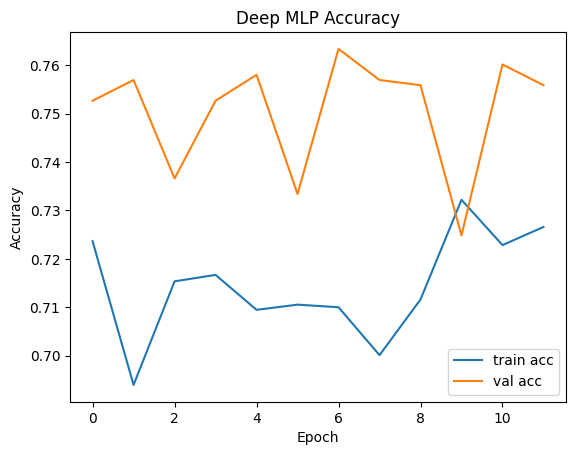

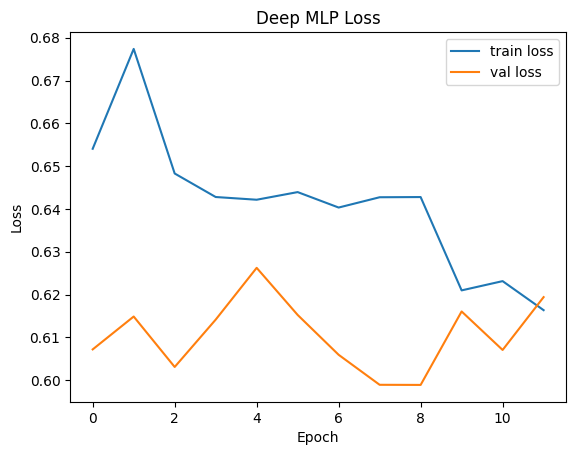

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_deep.history['accuracy'], label='train acc')
plt.plot(history_deep.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep MLP Accuracy'); plt.legend(); plt.show()

plt.plot(history_deep.history['loss'], label='train loss')
plt.plot(history_deep.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Deep MLP Loss'); plt.legend(); plt.show()


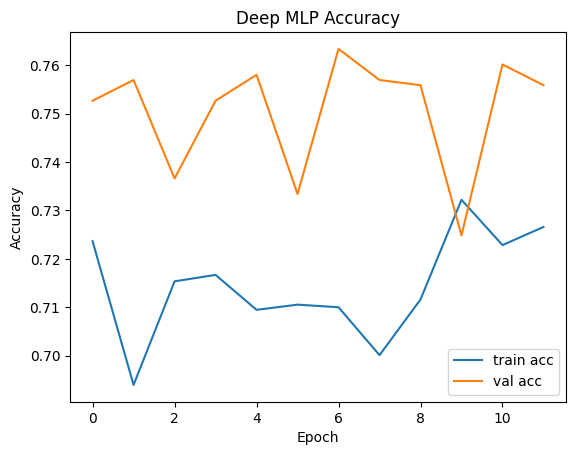

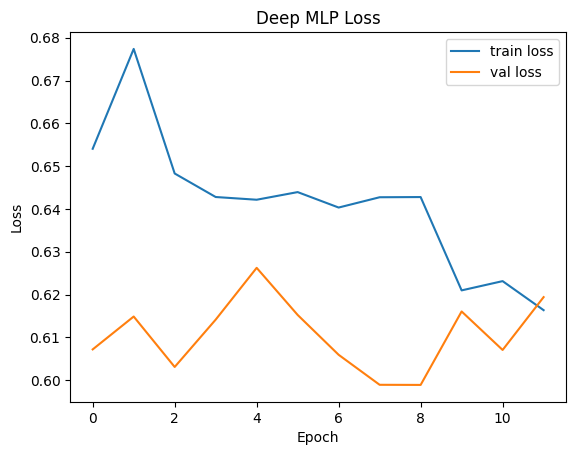

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history_deep.history['accuracy'], label='train acc')
plt.plot(history_deep.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep MLP Accuracy'); plt.legend()
plt.savefig("/content/drive/MyDrive/NIH_Dataset/deep_mlp_accuracy.png")  # save to Drive
plt.show()

# Loss plot
plt.plot(history_deep.history['loss'], label='train loss')
plt.plot(history_deep.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Deep MLP Loss'); plt.legend()
plt.savefig("/content/drive/MyDrive/NIH_Dataset/deep_mlp_loss.png")  # save to Drive
plt.show()


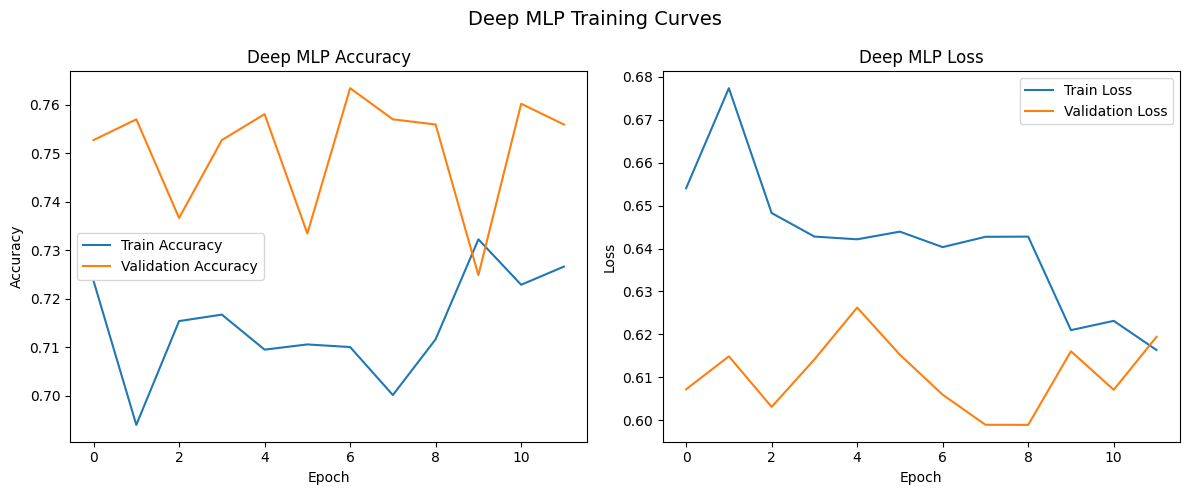

In [ ]:
import matplotlib.pyplot as plt

# Create figure with 2 plots (Accuracy and Loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_deep.history['accuracy'], label='Train Accuracy')
plt.plot(history_deep.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep MLP Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_deep.history['loss'], label='Train Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deep MLP Loss')
plt.legend()

# Main title for both plots
plt.suptitle("Deep MLP Training Curves", fontsize=14)

# Adjust layout and save
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/NIH_Dataset/deep_mlp_training_curves.png")  # ✅ Saves to Google Drive
plt.show()
